In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.datasets import make_classification  # Not used, but for potential extensions
import seaborn as sns

In [ ]:
df = pd.read_csv("preprocessed_stress_level_dataset.csv")
print(f"Dataset shape: {df.shape}")
print(f"Class distribution:\n{df['stress_level'].value_counts()}")

Dataset shape: (1100, 13)
Class distribution:
stress_level
0    373
2    369
1    358
Name: count, dtype: int64


In [ ]:
# Size of testing and training
def prepare_data(df):
    X = df.iloc[:, :-1].values  # Features: columns 0-11
    y = df['stress_level'].values  # Target
    return X, y

def split_data(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    print(f"Training set size: {X_train.shape[0]}")
    print(f"Test set size: {X_test.shape[0]}")
    return X_train, X_test, y_train, y_test

X, y = prepare_data(df)
X_train, X_test, y_train, y_test = split_data(X, y)

Training set size: 880
Test set size: 220


In [ ]:
# Feature names for plotting (assuming 12 features)
feature_names = [f'feature_{i}' for i in range(X.shape[1])]
class_names = ['0', '1', '2']  # Stress levels
target_names = ['Low Stress', 'Medium Stress', 'High Stress']

In [ ]:
# Train Decision Tree Model
from sklearn.tree import DecisionTreeClassifier

# Initialize and fit the model with random_state=42 using X_train and y_train
model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(X_train, y_train)

# Print max depth
print(f"Max Depth: {model_dt.get_depth()}")

# Print feature importances as a pandas Series
importances = pd.Series(model_dt.feature_importances_, index=feature_names)
print("Feature Importance:")
print(importances)

Max Depth: 14
Feature Importance:
feature_0     0.351143
feature_1     0.499141
feature_2     0.018081
feature_3     0.016810
feature_4     0.013338
feature_5     0.002273
feature_6     0.034352
feature_7     0.008499
feature_8     0.015748
feature_9     0.019586
feature_10    0.013698
feature_11    0.007331
dtype: float64


In [ ]:
# Evaluate Model Performance
# Predict on test set
y_pred_dt = model_dt.predict(X_test)

# Compute metrics (macro-averaged for multi-class)
accuracy = accuracy_score(y_test, y_pred_dt)
precision = precision_score(y_test, y_pred_dt, average='macro')
recall = recall_score(y_test, y_pred_dt, average='macro')
f1 = f1_score(y_test, y_pred_dt, average='macro')
roc_auc = roc_auc_score(y_test, model_dt.predict_proba(X_test), multi_class='ovr', average='macro')

print(f"Decision Tree Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"ROC AUC: {roc_auc}")

Decision Tree Metrics:
Accuracy: 0.9045454545454545
Precision: 0.9046373717606594
Recall: 0.90503003003003
F1-Score: 0.9042463741648784
ROC AUC: 0.9286658233576043


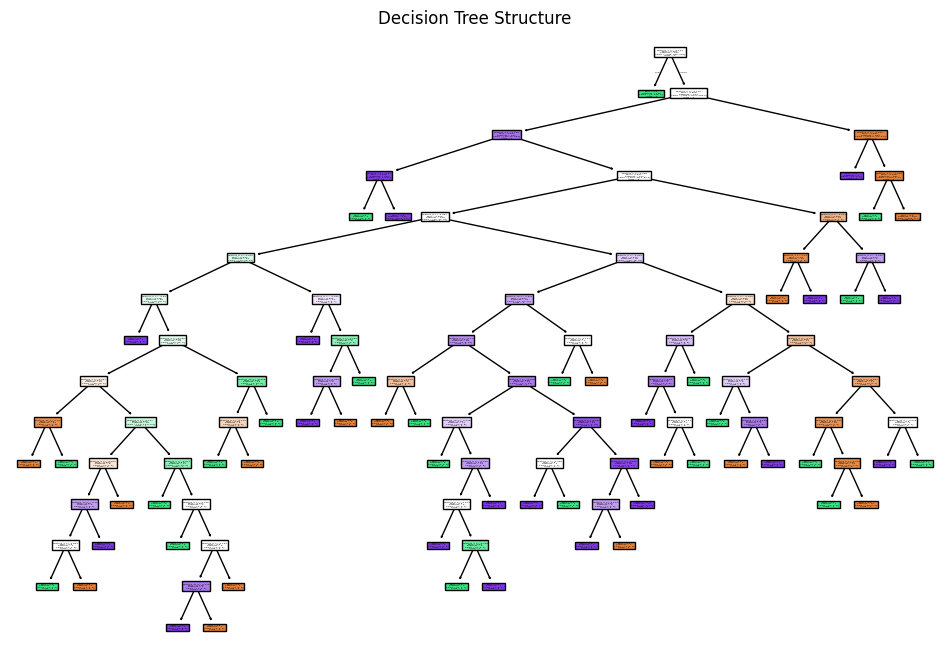

In [ ]:
# Plot the Decision Tree structure to visualize its hierarchical splits
plt.figure(figsize=(12, 8))
plot_tree(
    model_dt,
    feature_names=feature_names,
    class_names=class_names,
    filled=True
)
plt.title("Decision Tree Structure")
plt.show()

In [ ]:
# Reduce the 12-feature dataset to 2D using PCA for decision boundary visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train a Decision Tree model on the 2D PCA-transformed training data to create a decision boundary
model_dt_pca = DecisionTreeClassifier(random_state=42).fit(X_train_pca, y_train)

# Create a mesh grid to predict class labels across the 2D PCA space for the decision boundary
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
Z = model_dt_pca.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

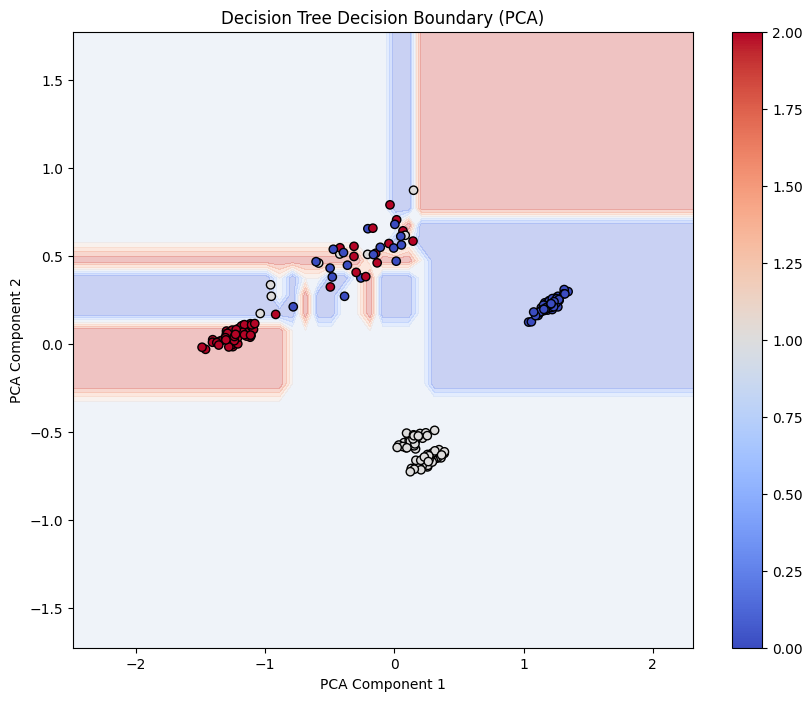

In [ ]:
# Plot the decision boundary and test data points to show class separation
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
scatter = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='coolwarm', edgecolor='k')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Decision Tree Decision Boundary (PCA)")
plt.colorbar(scatter)
plt.show()

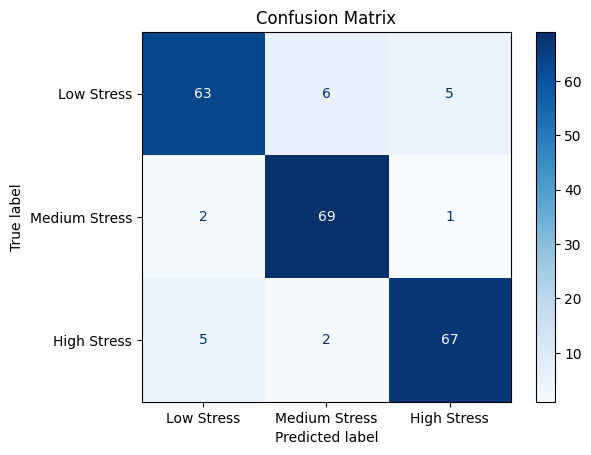

In [ ]:
# Plot the confusion matrix to visualize classification performance
cm = confusion_matrix(y_test, y_pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Experiment with Parameters and Analyze Behavior
# Loop over max_depth values [1, 3, 10] for the Decision Tree model
# For each max_depth, train a model, predict on X_test, and compute accuracy and F1-score

depths = [1, 3, 10]
results = []

for depth in depths:
    # Train model with max_depth=depth
    model_dt_exp = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model_dt_exp.fit(X_train, y_train)
    y_pred_exp = model_dt_exp.predict(X_test)

    # Compute metrics
    acc = accuracy_score(y_test, y_pred_exp)
    precision = precision_score(y_test, y_pred_exp, average='macro')
    recall = recall_score(y_test, y_pred_exp, average='macro')
    f1 = f1_score(y_test, y_pred_exp, average='macro')
    roc_auc = roc_auc_score(y_test, model_dt_exp.predict_proba(X_test), multi_class='ovr', average='macro')

    print(f"Decision Tree (max_depth={depth}) Metrics:")
    print(f"Accuracy: {acc}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print(f"ROC AUC: {roc_auc}")

    results.append({'Max Depth': depth, 'Accuracy': acc, 'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'ROC AUC': roc_auc})

Decision Tree (max_depth=1) Metrics:
Accuracy: 0.6272727272727273
Precision: 0.4914529914529915
Recall: 0.6296296296296297
F1-Score: 0.5282182438192669
ROC AUC: 0.7942668696093355
Decision Tree (max_depth=3) Metrics:
Accuracy: 0.8863636363636364
Precision: 0.9158249158249158
Recall: 0.8863863863863863
F1-Score: 0.8889656025671974
ROC AUC: 0.9841793848643164
Decision Tree (max_depth=10) Metrics:
Accuracy: 0.8954545454545455
Precision: 0.8959562006620829
Recall: 0.896021021021021
F1-Score: 0.8951066578441567
ROC AUC: 0.9463526026026026


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Print a summary table of results
results_df = pd.DataFrame(results)
print("\nSummary Table:")
print(results_df)


Summary Table:
   Max Depth  Accuracy  Precision    Recall  F1-Score   ROC AUC
0          1  0.627273   0.491453  0.629630  0.528218  0.794267
1          3  0.886364   0.915825  0.886386  0.888966  0.984179
2         10  0.895455   0.895956  0.896021  0.895107  0.946353
